# 재활용 품목 분류를 위한 Object Detection

목표: 사진에서 쓰레기를 detection 하여 분리수거에 도움이 되는 모델을 만들자.

## 평가방법
**mAP50(Mean Average Precision)**
- GT와 prediction box간 IoU 50 넘으면 True라 판단

## 데이터셋
- 전체 이미지 개수: 9,754장, 이 중 4,883장 train, 4,871장 test
- 10 classs: General trash, Paper, Paper pack, Metal, Glass, Plastic, Styrofoam, Plastic bag, Battery, Clothing
- 이미지 크기 : (1024, 1024)

## annotation file
annotation file은 coco format 으로 이루어져 있습니다.  
coco format은 크게 2가지 (images, annotations)의 정보를 가지고 있습니다.  

- images:
    - id: 파일 안에서 image 고유 id, ex) 1
    - height: 1024
    - width: 1024
    - filename: ex) train/002.jpg

- annotations: (참고 : detection 대회에서는 아래의 모든 정보를 활용 가능합니다.)
    - id: 파일 안에 annotation 고유 id, ex) 1
    - bbox: 객체가 존재하는 박스의 좌표 (xmin, ymin, w, h)
    - area: 객체가 존재하는 박스의 크기
    - category_id: 객체가 해당하는 class의 id
    - image_id: annotation이 표시된 이미지 고유 id

## 궁금한것
EDA part
- ~~한 데이터당 박스 몇개?~~
- ~~class의 분포는~~
    - CV split 반영
- ~~박스 크기의 분포는?~~
- ~~박스 크기의 비율은?~~
- ~~class별 박스 크기가 다를까?~~
- ~~한개의 이미지에 몇개의 class~~
- ~~객체의 위치는 어떻게 될까?~~
- ~~적절한 detection에서 augmenation 뭘까?(augmentation 시각화 따로)~~
- 데이터 부족 문제 어떻게 해결?
- 픽셀의 평균과 표준편차
- train, test 이미지의 픽셀 분포는 다를까?
- ~~객체의 위치는 어떻게 될까?~~
- RGB 채널별 통계값
- crop 하여 채널 통계깞
- ~~Data augmentation 하여 박스 시각화해보기~~

----------------------------------
이 밑은 모델부분에서 해결
- 해상도 조정이 모델에 어떤 영향
- 어떤 class를 잘 예측할까?
- 박스가 크기가 모델의 예측에 영향을 주겠지..? 당연히
- 

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
with open("../dataset/train.json") as f:
    train = json.load(f)

with open("../dataset/test.json") as f:
    test = json.load(f)

In [3]:
print(f"The number of train images : {len(train['images']):,}")
print(f"The number of test images : {len(test['images']):,}")
print(f"The number of classes : {len(train['categories'])}")
display(train['categories'])

print(f"Total number of annotation: {len(train['annotations']):,}")


The number of train images : 4,883
The number of test images : 4,871
The number of classes : 10


[{'id': 0, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 1, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 2, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 3, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 4, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 5, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 7, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 8, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 9, 'name': 'Clothing', 'supercategory': 'Clothing'}]

Total number of annotation: 23,144


In [7]:
train

{'info': {'year': 2021,
  'version': '1.0',
  'description': 'Recycle Trash',
  'contributor': 'Upstage',
  'url': None,
  'date_created': '2021-02-02 01:10:00'},
 'licenses': [{'id': 0,
   'name': 'CC BY 4.0',
   'url': 'https://creativecommons.org/licenses/by/4.0/deed.ast'}],
 'images': [{'width': 1024,
   'height': 1024,
   'file_name': 'train/0000.jpg',
   'license': 0,
   'flickr_url': None,
   'coco_url': None,
   'date_captured': '2020-12-26 14:44:23',
   'id': 0},
  {'width': 1024,
   'height': 1024,
   'file_name': 'train/0001.jpg',
   'license': 0,
   'flickr_url': None,
   'coco_url': None,
   'date_captured': '2021-01-10 16:30:39',
   'id': 1},
  {'width': 1024,
   'height': 1024,
   'file_name': 'train/0002.jpg',
   'license': 0,
   'flickr_url': None,
   'coco_url': None,
   'date_captured': '2020-12-27 17:55:52',
   'id': 2},
  {'width': 1024,
   'height': 1024,
   'file_name': 'train/0003.jpg',
   'license': 0,
   'flickr_url': None,
   'coco_url': None,
   'date_captur

In [8]:
category_map = {x['id']: x['name'] for x in train['categories']}
category_map

{0: 'General trash',
 1: 'Paper',
 2: 'Paper pack',
 3: 'Metal',
 4: 'Glass',
 5: 'Plastic',
 6: 'Styrofoam',
 7: 'Plastic bag',
 8: 'Battery',
 9: 'Clothing'}

In [9]:
df_images = pd.json_normalize(train['images'])
df_annotations = pd.json_normalize(train['annotations'])
train_df = df_images.set_index('id').join(df_annotations.set_index('image_id')).set_index('id')

category_map = {x['id']: x['name'] + "("+str(x['id']) + ")" for x in train['categories']}
train_df['category_name'] = train_df['category_id'].map(category_map)
train_df['image_id'] = train_df['file_name'].apply(lambda x: x.split('/')[1].split('.')[0])
train_df.head()

width  height       file_name  license flickr_url coco_url  \
id                                                               
0    1024    1024  train/0000.jpg        0       None     None   
1    1024    1024  train/0001.jpg        0       None     None   
2    1024    1024  train/0001.jpg        0       None     None   
3    1024    1024  train/0001.jpg        0       None     None   
4    1024    1024  train/0001.jpg        0       None     None   

          date_captured  category_id       area                          bbox  \
id                                                                              
0   2020-12-26 14:44:23            0  257301.66  [197.6, 193.7, 547.8, 469.7]   
1   2021-01-10 16:30:39            3   10402.56     [0.0, 407.4, 57.6, 180.6]   
2   2021-01-10 16:30:39            7   26259.36    [0.0, 455.6, 144.6, 181.6]   
3   2021-01-10 16:30:39            4   69096.17  [722.3, 313.4, 274.3, 251.9]   
4   2021-01-10 16:30:39            5   24164.58  [353.2, 671.0, 233.7, 103.4]   

    iscrowd     category_name image_id  
id                                      
0         0  General trash(0)     0000  
1         0          Metal(3)     0001  
2         0    Plastic bag(7)     0001  
3         0          Glass(4)     0001  
4         0        Plastic(5)     0001

## bbox class 수 & class를 갖고 있는 이미지 수

In [21]:
object_cnt.values/object_cnt.sum()*100

array([27.44555824, 22.37296924, 17.13619081, 12.71603871,  5.45713792,
        4.24300035,  4.04424473,  3.87573453,  2.02212236,  0.68700311])

/opt/conda/envs/detection/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/envs/detection/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


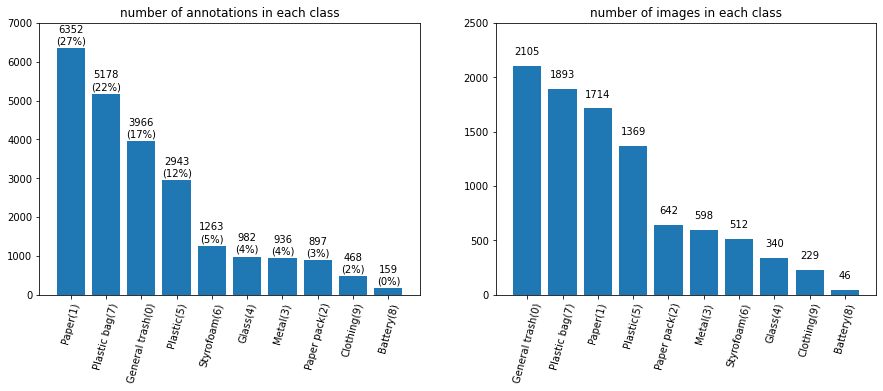

In [23]:
f, axs = plt.subplots(1,2,figsize=(15,5))

object_cnt = train_df['category_name'].value_counts().sort_values(ascending=False)
axs[0].bar(object_cnt.index, object_cnt.values)
for x,y,z in zip(object_cnt.index, object_cnt.values,object_cnt.values/object_cnt.sum()*100):                                       # <--
    axs[0].annotate('%d\n(%d%%)' %(int(y),z), xy=(x,y+100), textcoords='data', ha = 'center') 
axs[0].axis(ymin=0,ymax=7000)
axs[0].set_xticklabels(object_cnt.index, rotation = 75)
axs[0].set_title("number of annotations in each class")


img_cnt = train_df.groupby('category_name')['image_id'].nunique().sort_values(ascending=False)
axs[1].bar(img_cnt.index, img_cnt.values)
for xy in zip(img_cnt.index, img_cnt.values):                                       # <--
    axs[1].annotate('%d' % int(xy[1]), xy=(xy[0],xy[1]+100), textcoords='data', ha = 'center') 
axs[1].axis(ymin=0,ymax=2500)
axs[1].set_xticklabels(img_cnt.index, rotation = 75)
axs[1].set_title("number of images in each class")

plt.show()

> <font color='red'>validation set 구성을 어떻게 할지를 위의 결과를 반영<a id='m2'></a></font>
- startified group k-fold


category name별 area 비교

## BBOX AREA

In [28]:
train_df.groupby('category_name')['area'].describe()

count           mean            std      min         25%  \
category_name                                                                 
Battery(8)         159.0   50409.963711   48461.271709  1639.08  22835.1100   
Clothing(9)        468.0  189349.355983  205208.635554   867.92  39242.9575   
General trash(0)  3966.0   78860.147368  139422.920453     0.56   4938.0375   
Glass(4)           982.0   69338.117495   90700.947589   666.05  13367.2425   
Metal(3)           936.0   91644.378526  120828.132732   275.12   8136.8250   
Paper pack(2)      897.0   76116.495072   97160.645284    66.25   9238.1800   
Paper(1)          6352.0   92044.196322  141316.534122     3.12   9473.8450   
Plastic bag(7)    5178.0  110357.698233  139559.633291   301.71  17805.7650   
Plastic(5)        2943.0   80990.612409  124858.599769   105.08   7651.0950   
Styrofoam(6)      1263.0   97589.452375  122225.182798   682.95  18536.3200   

                         50%          75%         max  
category_name                                          
Battery(8)         38101.420   60976.1300   285908.24  
Clothing(9)       118000.110  257727.2750  1047961.69  
General trash(0)   19481.535   87530.2350  1048064.06  
Glass(4)           34655.040   91455.9000   699923.90  
Metal(3)           46016.250  123657.4400   745866.82  
Paper pack(2)      35691.840  107663.1200   900676.93  
Paper(1)           35645.330  114932.7675  1048064.06  
Plastic bag(7)     62505.200  146878.8900  1048371.21  
Plastic(5)         28801.000   99308.4650  1047961.69  
Styrofoam(6)       51485.060  128837.1750   992374.78

<Figure size 648x648 with 0 Axes>

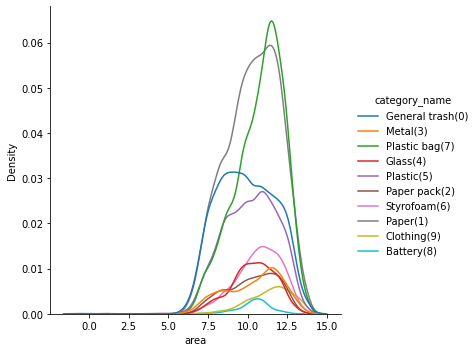

In [29]:
fig = plt.figure(figsize=(9, 9))
sns.displot(x = np.log(train_df['area']), 
hue = 'category_name', 
data = train_df,
kind = 'kde')


In [124]:
color_dict = {0:(0,0,255), 1:(0,50,255), 2:(0,255,255), 3:(0,255,100), 4:(0,255,0), 
5:(100,255,0), 6:(255,0,0), 7:(255,5,0), 8:(255,0,100), 9:(255,255,255)}

train_df.loc[train_df['area']<=302]

width  height       file_name  license flickr_url coco_url  \
id                                                                  
5067    1024    1024  train/1056.jpg        0       None     None   
5159    1024    1024  train/1063.jpg        0       None     None   
6539    1024    1024  train/1377.jpg        0       None     None   
7227    1024    1024  train/1521.jpg        0       None     None   
12473   1024    1024  train/2630.jpg        0       None     None   
17594   1024    1024  train/3712.jpg        0       None     None   

             date_captured  category_id    area                       bbox  \
id                                                                           
5067   2020-12-25 17:05:01            5  105.08   [530.6, 70.9, 14.2, 7.4]   
5159   2021-04-27 14:26:07            0    0.56   [647.8, 460.2, 0.7, 0.8]   
6539   2021-01-09 16:09:14            1    3.12   [719.8, 604.7, 1.3, 2.4]   
7227   2021-01-06 17:17:42            3  275.12  [728.4, 307.8, 36.2, 7.6]   
12473  2021-01-03 12:23:00            7  301.71  [570.2, 822.5, 8.9, 33.9]   
17594  2020-12-28 16:17:48            2   66.25  [883.8, 638.5, 12.5, 5.3]   

       iscrowd     category_name image_id  
id                                         
5067         0        Plastic(5)     1056  
5159         0  General trash(0)     1063  
6539         0          Paper(1)     1377  
7227         0          Metal(3)     1521  
12473        0    Plastic bag(7)     2630  
17594        0     Paper pack(2)     3712

<Figure size 432x288 with 0 Axes>

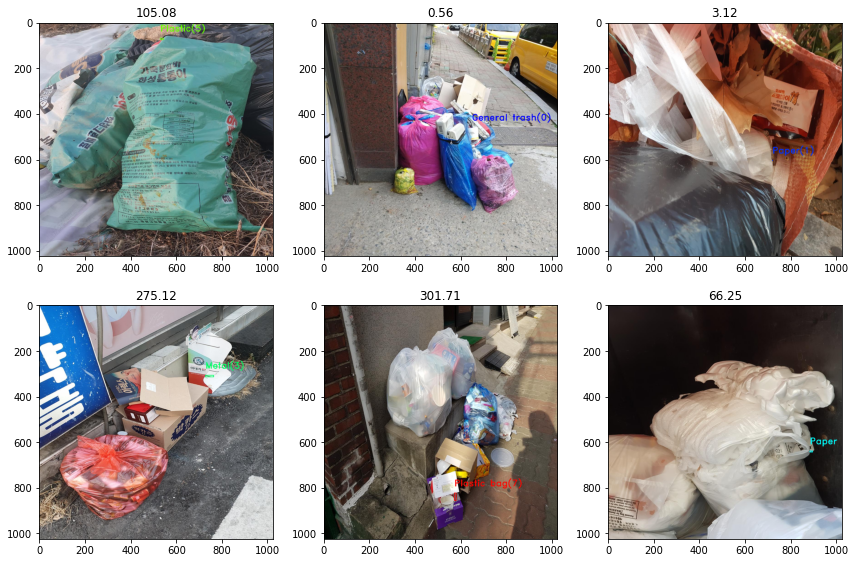

In [125]:
plt.clf()
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()

for i, idx in enumerate(train_df.loc[train_df['area']<=302, 'image_id'].index):
    img = cv2.imread("../dataset/"+train_df.loc[idx,'file_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    select_data = train_df.loc[idx]

    # img = io.imread("../dataset/"+train_df.loc[idx,'file_name']) 
    # select_data = train_df.loc[idx]

    bbox = list(map(float, select_data['bbox']))
    category = int(select_data['category_id'])
    category_name = select_data['category_name']
    color = color_dict[category]
    x,y, w, h = bbox

    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.rectangle(img, (int(x),int(y)), (int(x)+int(w),int(y)+int(h)), color, 2) 
    cv2.putText(img, category_name, (int(x),int(y)-30), font, 1.3, color, 2)

    ax[i].imshow(img)
    ax[i].set_title(select_data['area'])
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

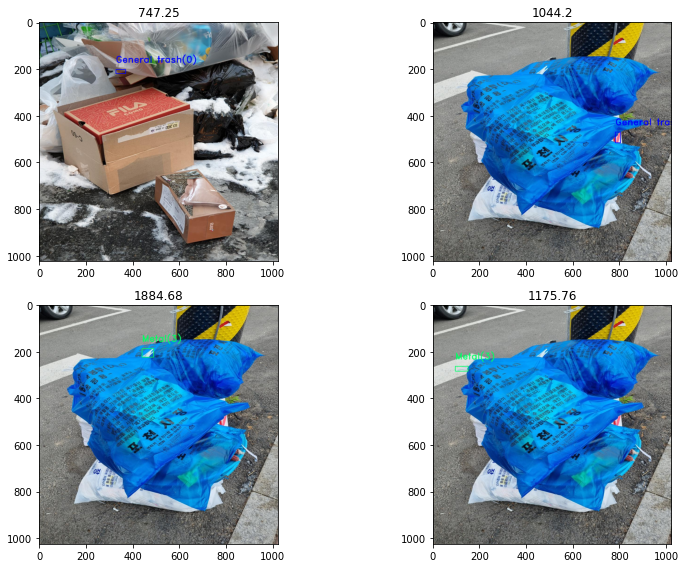

In [202]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()

for i, idx in enumerate(train_df.loc[train_df['area']<=2000, 'image_id'].index[:4]):
    img = cv2.imread("../dataset/"+train_df.loc[idx,'file_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    select_data = train_df.loc[idx]

    # img = io.imread("../dataset/"+train_df.loc[idx,'file_name']) 
    # select_data = train_df.loc[idx]

    bbox = list(map(float, select_data['bbox']))
    category = int(select_data['category_id'])
    category_name = select_data['category_name']
    color = color_dict[category]
    x,y, w, h = bbox

    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.rectangle(img, (int(x),int(y)), (int(x)+int(w),int(y)+int(h)), color, 2) 
    cv2.putText(img, category_name, (int(x),int(y)-30), font, 1.3, color, 2)

    ax[i].imshow(img)
    ax[i].set_title(select_data['area'])
plt.tight_layout()
plt.show()

작으면 작다는 크기가 얼마인지 그렇다면 작은 것들 어떻게 처리 할것인지 생각...

<Figure size 432x288 with 0 Axes>

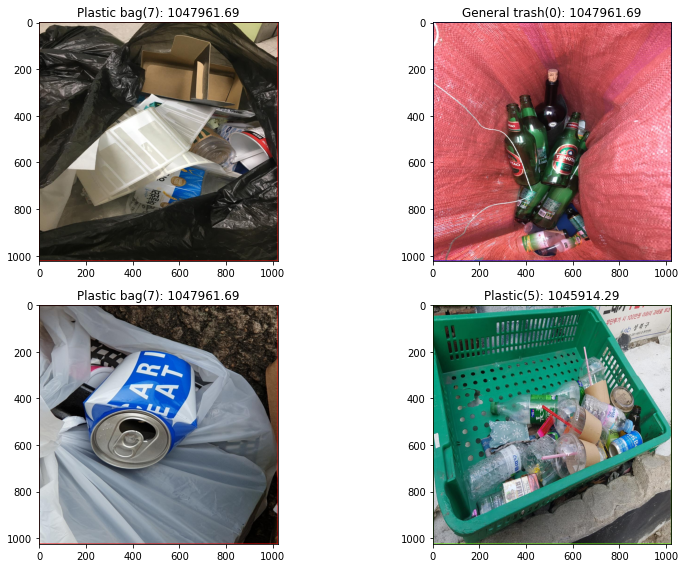

In [138]:
plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()

for i, idx in enumerate(train_df.loc[train_df['area']>=1000000, 'image_id'].index[:4]):
    img = cv2.imread("../dataset/"+train_df.loc[idx,'file_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    select_data = train_df.loc[idx]

    # img = io.imread("../dataset/"+train_df.loc[idx,'file_name']) 
    # select_data = train_df.loc[idx]

    bbox = list(map(float, select_data['bbox']))
    category = int(select_data['category_id'])
    category_name = select_data['category_name']
    color = color_dict[category]
    x,y, w, h = bbox

    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.rectangle(img, (int(x),int(y)), (int(x)+int(w),int(y)+int(h)), color, 2) 
    cv2.putText(img, category_name, (int(x),int(y)-30), font, 1.3, color, 2)

    ax[i].imshow(img)
    ax[i].set_title(category_name+": "+str(select_data['area']))
plt.tight_layout()
plt.show()

In [147]:
train_df.loc[train_df['area'] >= 800000].shape

(117, 13)

<Figure size 432x288 with 0 Axes>

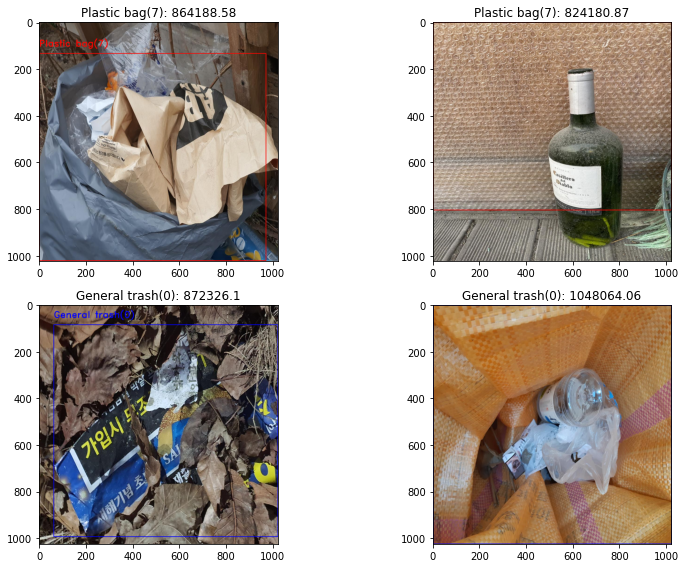

In [146]:
#plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()

for i, idx in enumerate(train_df.loc[train_df['area']>=800000, 'image_id'].index[-4:]):
    img = cv2.imread("../dataset/"+train_df.loc[idx,'file_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    select_data = train_df.loc[idx]

    # img = io.imread("../dataset/"+train_df.loc[idx,'file_name']) 
    # select_data = train_df.loc[idx]

    bbox = list(map(float, select_data['bbox']))
    category = int(select_data['category_id'])
    category_name = select_data['category_name']
    color = color_dict[category]
    x,y, w, h = bbox

    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.rectangle(img, (int(x),int(y)), (int(x)+int(w),int(y)+int(h)), color, 2) 
    cv2.putText(img, category_name, (int(x),int(y)-30), font, 1.3, color, 2)

    ax[i].imshow(img)
    ax[i].set_title(category_name+": "+str(select_data['area']))
plt.tight_layout()
plt.show()

- 분포가 다를 수 있다고 볼 수 있냐? 음 잘 모르곘다. 
- 일단은 베터리가 좀 바운딩 박스가 큰게 없는것 같다
- 바운딩박스 크기 이상치 존재 매우 작은것 or 매우 큰것
-  <font color='red'>사진 밖에 범위 넘어가는 박스도 있는듯(조정필요) -> 코드 짜기<a id='m1'></a></font>
- 엄청 큰것들 도 있고 엄청 작은것도 있고

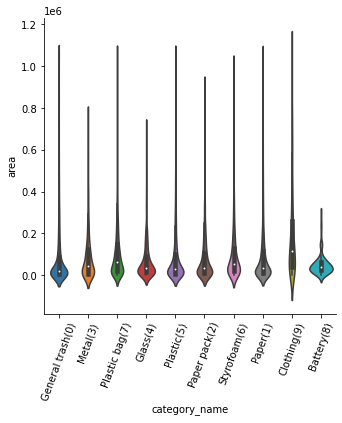

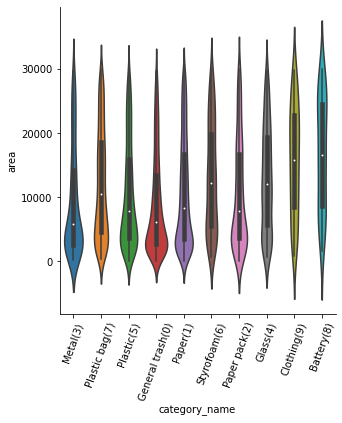

In [191]:

# ax = sns.catplot(x="category_name", y="area", data=train_df,kind='violin')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
g = sns.catplot(x="category_name", y="area", data=train_df,kind='violin')
g.set_xticklabels(rotation=70)
plt.show()

g = sns.catplot(x="category_name", y="area", data=train_df.loc[train_df['area']<=30000],kind='violin')
g.set_xticklabels(rotation=70)
plt.show()

## Width, height, ratio in each class

In [195]:
train_df['bbox_width'] = train_df['bbox'].apply(lambda x: x[2])
train_df['bbox_height'] = train_df['bbox'].apply(lambda x: x[3])
train_df['bbox_ratio'] = train_df['bbox_width']/train_df['bbox_height']

In [222]:
pd.DataFrame(train_df[['bbox_width', 'bbox_height', 'bbox_ratio']].describe().transpose())

count        mean         std       min        25%         50%  \
bbox_width   23144.0  257.499170  204.582362  0.700000  99.750000  200.900000   
bbox_height  23144.0  252.241518  200.143898  0.800000  93.500000  196.100000   
bbox_ratio   23144.0    1.298707    1.166790  0.055391   0.691147    1.047518   

                    75%          max  
bbox_width   357.650000  1023.900000  
bbox_height  359.825000  1023.900000  
bbox_ratio     1.537306    27.285714

Text(0.5, 0.98, 'Main')

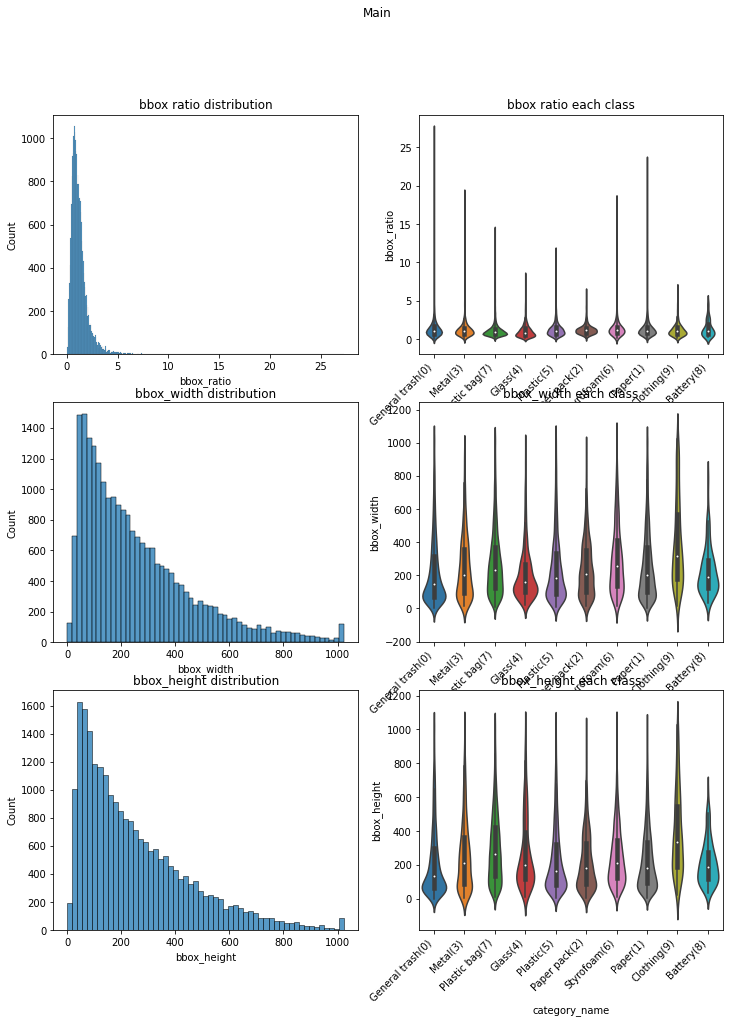

In [230]:
fig, axes = plt.subplots(3, 2, figsize=(12,15))
axes = axes.flatten()

g1 = sns.histplot(train_df, x="bbox_ratio",ax = axes[0])
g2 = sns.violinplot(x='category_name', y='bbox_ratio', data=train_df, ax = axes[1])
axes[0].set_title("bbox ratio distribution")
axes[1].set_title("bbox ratio each class")

g2.set_xticklabels(g.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light'
                 )

g3 = sns.histplot(train_df, x="bbox_width",ax = axes[2])
g4 = sns.violinplot(x='category_name', y='bbox_width', data=train_df, ax = axes[3])
axes[2].set_title("bbox_width distribution")
axes[3].set_title("bbox_width each class")

g4.set_xticklabels(g.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light'
                 )

g5 = sns.histplot(train_df, x="bbox_height",ax = axes[4])
g6 = sns.violinplot(x='category_name', y='bbox_height', data=train_df, ax = axes[5])
axes[4].set_title("bbox_height distribution")
axes[5].set_title("bbox_height each class")

g6.set_xticklabels(g.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light'
                 )


plt.suptitle("Main")

## Check bbox number in a image

count      mean       std  min  25%  50%  75%   max
image_id  4883.0  4.739709  6.355155  1.0  1.0  2.0  6.0  71.0

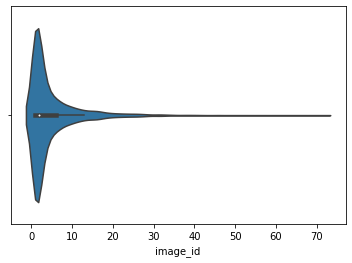

In [40]:
display(pd.DataFrame(train_df['image_id'].value_counts().describe()).transpose())
sns.violinplot(x = train_df['image_id'].value_counts())
plt.show()

<Figure size 432x288 with 0 Axes>

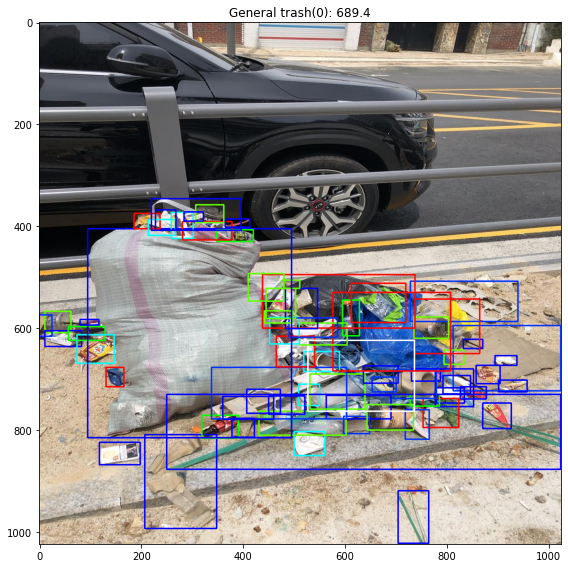

In [173]:
plt.clf()
fig = plt.figure(figsize=(12, 8))
idx = img_cnt.index[0]
img = cv2.imread("../dataset/"+train_df.loc[train_df['image_id'] == img_cnt.index[0],'file_name'].iloc[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


for idx in train_df.loc[train_df['image_id'] == img_cnt.index[0],'file_name'].index:
    select_data = train_df.loc[idx]
    bbox = list(map(float, select_data['bbox']))
    category = int(select_data['category_id'])
    category_name = select_data['category_name']
    color = color_dict[category]
    x,y, w, h = bbox

    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.rectangle(img, (int(x),int(y)), (int(x)+int(w),int(y)+int(h)), color, 2) 
    #cv2.putText(img, scategory_name, (int(x),int(y)-30), font, 1.3, color, 2)

plt.imshow(img)
plt.title(category_name+": "+str(select_data['area']))
plt.tight_layout()
plt.show()

## Center (x, y)

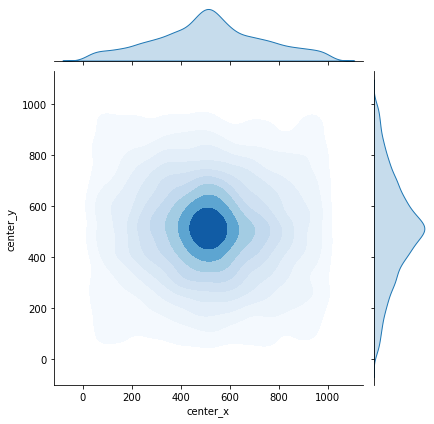

In [243]:
train_df['center_x'] = train_df['bbox'].apply(lambda x: x[0]) + train_df['bbox_width']/2
train_df['center_y'] = train_df['bbox'].apply(lambda x: x[1]) + train_df['bbox_height']/2

sns.jointplot(x='center_x', y='center_y',data=train_df
             ,kind = 'kde', fill = True, cmap = "Blues")

## train valid split

In [ ]:
df_images = pd.json_normalize(train['images'])
df_annotations = pd.json_normalize(train['annotations'])
train_df = df_images.set_index('id').join(df_annotations.set_index('image_id')).set_index('id')

category_map = {x['id']: x['name'] + "("+str(x['id']) + ")" for x in train['categories']}
train_df['category_name'] = train_df['category_id'].map(category_map)
train_df['image_id'] = train_df['file_name'].apply(lambda x: x.split('/')[1].split('.')[0])
train_df.head()

In [37]:
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from collections import Counter, defaultdict

In [56]:
skf = StratifiedGroupKFold(n_splits = 5, random_state = 42, shuffle = True) 
for trn_idx, val_idx in skf.split(df_annotations['id'], df_annotations['category_id'], df_annotations['image_id']):
    break;
# image_id별로 다 묶인것을 확인
sum([x in list(df_annotations.loc[val_idx]['image_id'].unique()) for x in df_annotations.loc[trn_idx]['image_id'].unique()])

0

In [54]:
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]


distrs = [get_distribution(df_annotations['category_id'])]
index = ['training set']
train_x, train_y, groups = df_annotations['id'], df_annotations['category_id'], df_annotations['image_id']

for fold_ind, (dev_ind, val_ind) in enumerate(skf.split(train_x, train_y, groups)):
    dev_y, val_y = train_y[dev_ind], train_y[val_ind]
    dev_groups, val_groups = groups[dev_ind], groups[val_ind]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_y) + 1)])

'Distribution per class:'

Label 0 Label 1 Label 2 Label 3 Label 4 Label 5  \
training set              17.14%  27.45%   3.88%   4.04%   4.24%  12.72%   
development set - fold 0  17.48%  27.48%   3.76%   3.93%   4.38%  12.46%   
validation set - fold 0   15.66%  27.28%   4.38%   4.54%   3.64%  13.81%   
development set - fold 1  17.38%  26.57%   3.96%   4.37%   4.03%  12.95%   
validation set - fold 1   16.28%  30.56%   3.59%   2.89%   4.99%  11.90%   
development set - fold 2  17.05%  27.15%   3.98%   4.07%   4.07%  13.04%   
validation set - fold 2   17.49%  28.60%   3.48%   3.93%   4.91%  11.43%   
development set - fold 3  17.06%  28.15%   3.86%   3.83%   4.40%  12.38%   
validation set - fold 3   17.46%  24.59%   3.94%   4.90%   3.61%  14.09%   
development set - fold 4  16.73%  27.85%   3.83%   4.03%   4.32%  12.76%   
validation set - fold 4   18.86%  25.75%   4.05%   4.12%   3.92%  12.53%   

                         Label 6 Label 7 Label 8 Label 9  
training set               5.46%  22.37%   0.69%   2.02%  
development set - fold 0   5.44%  22.57%   0.70%   1.80%  
validation set - fold 0    5.54%  21.52%   0.65%   2.98%  
development set - fold 1   5.65%  22.28%   0.63%   2.19%  
validation set - fold 1    4.77%  22.70%   0.88%   1.43%  
development set - fold 2   5.37%  22.74%   0.57%   1.95%  
validation set - fold 2    5.80%  20.93%   1.13%   2.29%  
development set - fold 3   5.23%  22.27%   0.74%   2.08%  
validation set - fold 3    6.37%  22.77%   0.48%   1.79%  
development set - fold 4   5.60%  22.00%   0.79%   2.10%  
validation set - fold 4    4.87%  23.95%   0.25%   1.71%

In [4]:
#df_annotations.to_dict()
def df_to_formatted_json(df, sep="."):
    """
    The opposite of json_normalize
    """
    result = []
    for idx, row in df.iterrows():
        parsed_row = {}
        for col_label,v in row.items():
            keys = col_label.split(".")

            current = parsed_row
            for i, k in enumerate(keys):
                if i==len(keys)-1:
                    current[k] = v
                else:
                    if k not in current.keys():
                        current[k] = {}
                    current = current[k]
        # save
        result.append(parsed_row)
    return result
# df_to_formatted_json(df_annotations)

In [5]:
train.keys()

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

In [6]:
trn_json = train.copy()
val_json = train.copy()
trn_json['images'] = df_to_formatted_json(df_images.loc[df_annotations.loc[trn_idx,'image_id'].unique()])
val_json['images'] = df_to_formatted_json(df_images.loc[df_annotations.loc[val_idx,'image_id'].unique()])

trn_json['annotations'] = df_to_formatted_json(df_annotations.loc[trn_idx])
val_json['annotations'] = df_to_formatted_json(df_annotations.loc[val_idx])

NameError: name 'df_images' is not defined

In [1]:
# import json
# import pandas as pd
# import cv2

In [3]:
with open("../dataset/train.json") as f:
    train = json.load(f)

with open("../dataset/trn_val_split_json/train_split_0.json") as f:
    train_split = json.load(f)

with open("../dataset/trn_val_split_json/valid_split_0.json") as f:
    valid_split = json.load(f)

In [75]:
# # train_df = pd.json_normalize(train['annotations'])
# train_df.loc[train_df['area'] <= 1000]

범위 넘어가는거 없다 잘못 본듯

In [76]:
train_df['x_max'] = train_df['bbox'].apply(lambda x: x[0]) + train_df['bbox'].apply(lambda x: x[2])
train_df['y_max'] = train_df['bbox'].apply(lambda x: x[1]) + train_df['bbox'].apply(lambda x: x[3])
train_df[['x_max', 'y_max']].describe()

x_max         y_max
count  23144.000000  23144.000000
mean     643.694824    634.471526
std      242.121960    226.021323
min       10.200000     12.700000
25%      475.400000    478.500000
50%      665.650000    647.600000
75%      830.000000    802.000000
max     1023.900000   1024.000000

픽셀별값

In [86]:
from tqdm import tqdm

def get_image_brightness(image):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # get average brightness
    return np.array(gray).mean()

def add_brightness(df):
    brightness = []
    for i, row in tqdm(df.iterrows()):
        img_id = "../dataset/"+ row.file_name
        image = cv2.imread(img_id)
        brightness.append(get_image_brightness(image))
        # if i%100 == 0:
        #     print(i, '번쨰 끝남')
        
    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns = ['brightness']
    df = pd.concat([df, brightness_df], ignore_index=True, axis=1)
    
    return df

In [94]:
pd.json_normalize(train['images']).columns.to_list() + ['a']

['width',
 'height',
 'file_name',
 'license',
 'flickr_url',
 'coco_url',
 'date_captured',
 'id',
 'a']

In [95]:
# # 밝기 계산
tr_img_df = pd.json_normalize(train['images'])
tr_img_df = add_brightness(tr_img_df)

te_img_df = pd.json_normalize(test['images'])
te_img_df = add_brightness(te_img_df)

tr_img_df.columns = pd.json_normalize(train['images']).columns.to_list() + ['brightness']
te_img_df.columns = pd.json_normalize(train['images']).columns.to_list() + ['brightness']

# 시간계산
tr_img_df['date_captured'] = pd.to_datetime(tr_img_df['date_captured'], format = "%Y-%m-%d %H:%M:%S")
te_img_df['date_captured'] = pd.to_datetime(te_img_df['date_captured'], format = "%Y-%m-%d %H:%M:%S")
tr_img_df['hour'] = tr_img_df['date_captured'].apply(lambda x: x.hour)
te_img_df['hour'] = tr_img_df['date_captured'].apply(lambda x: x.hour)
# tr_img_df = br.copy()
# te_img_df = br_te.copy()

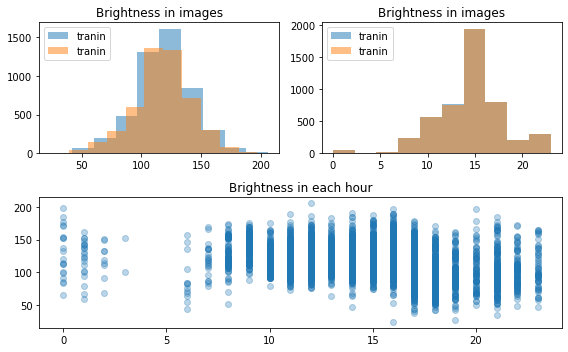

In [96]:
fig = plt.figure(figsize=(8, 5)) # initialize figure
ax = [None for _ in range(3)] # list to save many ax for setting parameter in each

ax[0] = plt.subplot2grid((2,2), (0,0), colspan=1)
ax[1] = plt.subplot2grid((2,2), (0,1), colspan=1)
ax[2] = plt.subplot2grid((2,2), (1,0), colspan=2)

ax[0].hist(tr_img_df['brightness'], alpha = 0.5, label = 'train')
ax[0].hist(te_img_df['brightness'], alpha = 0.5, label = 'test')
ax[0].legend(loc='upper left')
ax[0].set_title("Brightness in images")

ax[1].hist(tr_img_df['hour'], alpha = 0.5, label = 'train')
ax[1].hist(te_img_df['hour'], alpha = 0.5, label = 'test')
ax[1].legend(loc='upper left')
ax[1].set_title("Brightness in images")

ax[2].scatter(tr_img_df['hour'], tr_img_df['brightness'], alpha = 0.3)
ax[2].set_title("Brightness in each hour")

plt.tight_layout()
plt.show()

In [5]:
pd.json_normalize(train['images'])

width  height       file_name  license flickr_url coco_url  \
0      1024    1024  train/0000.jpg        0       None     None   
1      1024    1024  train/0001.jpg        0       None     None   
2      1024    1024  train/0002.jpg        0       None     None   
3      1024    1024  train/0003.jpg        0       None     None   
4      1024    1024  train/0004.jpg        0       None     None   
...     ...     ...             ...      ...        ...      ...   
4878   1024    1024  train/4878.jpg        0       None     None   
4879   1024    1024  train/4879.jpg        0       None     None   
4880   1024    1024  train/4880.jpg        0       None     None   
4881   1024    1024  train/4881.jpg        0       None     None   
4882   1024    1024  train/4882.jpg        0       None     None   

            date_captured    id  
0     2020-12-26 14:44:23     0  
1     2021-01-10 16:30:39     1  
2     2020-12-27 17:55:52     2  
3     2021-03-31 12:10:36     3  
4     2021-01-01 18:52:38     4  
...                   ...   ...  
4878  2021-01-04 14:36:54  4878  
4879  2021-04-27 13:46:18  4879  
4880  2020-12-24 11:25:46  4880  
4881  2021-01-05 11:01:18  4881  
4882  2020-12-23 16:20:30  4882  

[4883 rows x 8 columns]

In [7]:
from tqdm import tqdm

In [14]:
# path = '/opt/ml/detection/dataset/'
# red_array = np.array([], dtype = np.uint8); green_array = np.array([], dtype = np.uint8); blue_array = np.array([], dtype = np.uint8)
# for row in tqdm(pd.json_normalize(train['images']).iterrows()):
#     row = row[1]
#     img = cv2.imread(path+row['file_name'])
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     red_array = np.append(red_array, img[...,0]);
#     green_array = np.append(green_array,img[...,1]);
#     blue_array = np.append(blue_array, img[...,2])

539it [03:58,  1.15it/s]

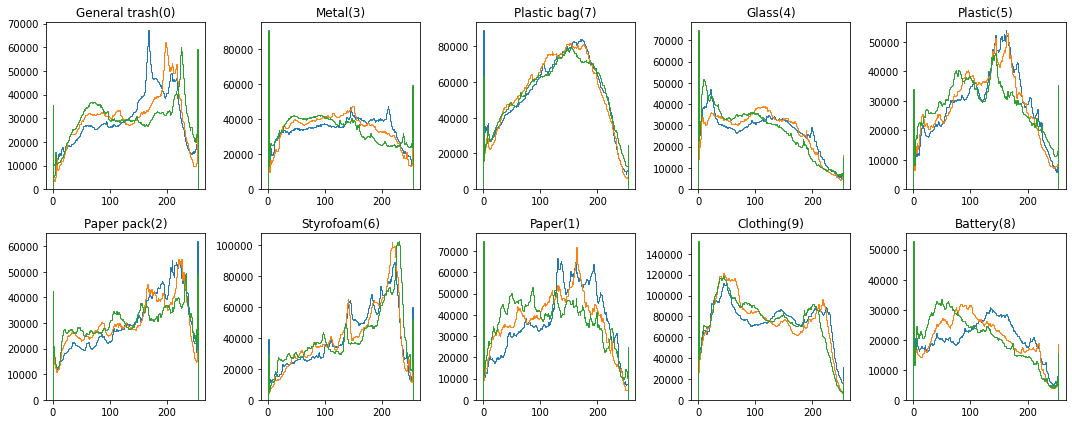

In [73]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
ax = ax.flatten()
for i, target_category in enumerate(train_df['category_name'].unique()):
    # 픽셀값 저장할 빈 array 지정
    red_array = np.array([], dtype = np.uint8); green_array = np.array([], dtype = np.uint8); blue_array = np.array([], dtype = np.uint8)
    
    # 해당 category 100개 샘플링
    for _, row in train_df.loc[train_df['category_name']==target_category].sample(100).iterrows():
        img = cv2.imread(path+row['file_name'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x, y, w, h = row['bbox']
        img = img[int(y):int(y+h),int(x):int(x+w)] # 이미지 불러와서 crop
        red_array = np.append(red_array, img[...,0]);
        green_array = np.append(green_array,img[...,1]);
        blue_array = np.append(blue_array, img[...,2])
        
    for col_array, color in zip([red_array, green_array, blue_array], ['red','green','blue']):
        ax[i].hist(col_array, range(0,255), histtype='step')
    ax[i].set_title(target_category)
plt.tight_layout()
plt.show()


In [105]:
cate_box_dict = dict()

def bbox2wh(bbox):
    return (round(bbox[2]), round(bbox[3]))

for anno in train['annotations']:
    if cate_box_dict.get(anno['category_id']):
        cate_box_dict[anno['category_id']].append(bbox2wh(anno['bbox']))
    else:
        cate_box_dict[anno['category_id']] = [bbox2wh(anno['bbox'])]

cate_boxsize_dict = dict()

for cate in cate_box_dict.keys():
    width = [box[0] for box in cate_box_dict[cate]]
    height = [box[1] for box in cate_box_dict[cate]]

    cate_boxsize_dict[cate] = (round(sum(width)/len(width),1), round(sum(height)/len(height), 1))

In [106]:
cate_boxsize_dict

{0: (226.2, 215.5),
 3: (251.0, 257.2),
 7: (275.4, 301.2),
 4: (206.1, 271.9),
 5: (239.4, 230.7),
 2: (244.9, 220.1),
 6: (299.2, 252.3),
 1: (263.9, 236.7),
 9: (394.7, 391.7),
 8: (228.9, 215.0)}

<AxesSubplot:xlabel='category_name', ylabel='category_name'>

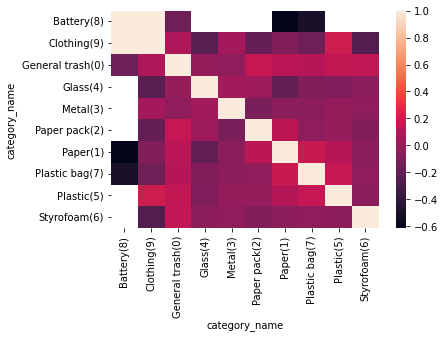

In [168]:
tmp_df = train_df.groupby('image_id')['category_name'].value_counts().rename("value")
tmp_df = tmp_df.reset_index(level = ['image_id','category_name']).pivot(index = "image_id", columns = 'category_name')
tmp_df.columns = tmp_df.columns.get_level_values(1)#.reset_index(drop = True)
tmp_df.reset_index(drop=True,inplace = True)#
sns.heatmap(tmp_df.corr())

구현 할 것
- [validation set 구분 코드 구현](#m2)
- [범위 넘어가는 박스 크기 조정](#m1)